# Imports

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.metrics import f1_score,recall_score, precision_score

import ast

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

%matplotlib inline

# Path and Load Data 

In [2]:
data = pd.read_csv('fitness_[actual_size=4665]_processed_merge.csv').fitness
data = pd.DataFrame(data=data)
data.head() 

,fitness
0,"['know', 'effect', 'exercis', 'leg', 'tricki',..."
1,"['stress', '😩', 'tire', '😴', 'worn', '😰', 'com..."
2,"['time', 'get', 'rockin', 'foam', 'rollin', 'l..."
3,"['hi', 'zach', 'pleas', 'dm', 'us', 'thank']"
4,"['hi', 'thank', 'reach', 'account', 'manag', '..."


In [3]:
INTEREST_positive_tweets = data[:4968] 
print('INTEREST tweets size :', len(INTEREST_positive_tweets))
INTEREST_negative_tweets = data[4968:] 
print('non-INTEREST tweets size :', len(INTEREST_negative_tweets))

INTEREST tweets size : 4968
non-INTEREST tweets size : 4697


* Train test split: 20% will be in the test set, and 80% in the training set.


In [4]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = INTEREST_positive_tweets[4000:]
train_pos = INTEREST_positive_tweets[:4000]

test_neg = INTEREST_negative_tweets[4000:]
train_neg = INTEREST_negative_tweets[:4000]

In [5]:
train_x = pd.concat([train_pos, train_neg], axis=0) 
test_x = pd.concat([test_pos, test_neg], axis=0)

- Create the numpy array of positive labels and negative labels.

In [6]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [7]:
print('train shape:', train_y.shape)
print('test shape:', test_y.shape)

train shape: (8000, 1)
test shape: (1665, 1)


# Vocabulary for Politics Dataset 

In [8]:
def generate_tweets_list(dataframe_single):
    train_x_arr = [] 
    for index, row in dataframe_single.iterrows(): 
        for a in row.values: 
            train_x_arr.append(ast.literal_eval(a))
            
    return train_x_arr

In [9]:
train_x_arr = generate_tweets_list(train_x)

In [10]:
def build_freqs(train_x, train_y):
    
    yslist = np.squeeze(train_y).tolist()
    
    freqs = {}
    for y, tweet in zip(yslist, train_x):
        for word in tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [11]:
freqs = build_freqs(train_x_arr, train_y) 
train_x_arr = generate_tweets_list(train_x)

In [12]:
len(freqs)

13456

In [13]:
freqs_vis = np.ndarray((1,2))

for (word, label), value in freqs.items(): 
    if label == 1.0: 
        freqs_vis = np.append(freqs_vis, [[word, value]], axis=0)

        
freqs_vis

array([['0.0', '0.0'],
       ['know', '184'],
       ['effect', '36'],
       ...,
       ['propos', '1'],
       ['davi', '1'],
       ['fl', '1']], dtype='<U37')

In [14]:
freqs_vis = np.delete(freqs_vis, 0, axis=0)

In [15]:
freqs_vis = pd.DataFrame(data=freqs_vis, columns=['word', 'frequency'])
freqs_vis.head()

,word,frequency
0,know,184
1,effect,36
2,exercis,73
3,leg,55
4,tricki,1


In [16]:
freqs_vis['frequency'] = freqs_vis['frequency'].astype('int')
freqs_vis = freqs_vis.nlargest(columns='frequency', n=20).iloc[2:,:]
freqs_vis

,word,frequency
71,pleas,440
518,club,404
19,us,377
147,fit,376
32,gym,362
305,’,331
106,help,309
74,reach,306
47,get,279
9,workout,254


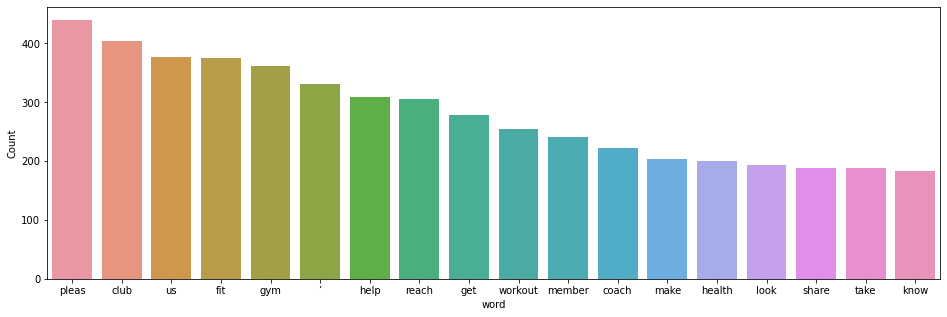

In [17]:
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=freqs_vis, x='word', y='frequency')
ax.set(ylabel = 'Count') 
plt.show() 

## Extract Features 
* Given a list of tweets, extract the features and store them in a matrix. Extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train the logistic regression classifier on these features.
* Test the classifier on a validation set. 

In [18]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet 
        freqs: a dictionary corresponding to the frequencies of each tuple 
    Output:
        x: a feature vector of dimension (1, 3)
    '''
    x = np.zeros((1, 3)) 
    x[0,0] = 1 # bias term  
    
    for word in tweet: 
        
        x[0,1] += freqs.get((word, 1.0), 0) 
        
        x[0,2] += freqs.get((word, 0.0), 0) 
        
    assert(x.shape == (1, 3))
    return x 

In [19]:
# Ex 
train_x_arr[0]

['know',
 'effect',
 'exercis',
 'leg',
 'tricki',
 'design',
 'quick',
 'effect',
 '15',
 'min',
 'workout',
 'knock',
 'park',
 'next',
 'leg',
 'day',
 'one',
 'els',
 'back',
 'shoulder',
 'leg',
 'like',
 'us',
 '💯']

In [20]:
extract_features(train_x_arr[0], freqs)

array([[1.000e+00, 1.779e+03, 8.920e+02]])

In [21]:
extract_features(['asd', 'asd', 'asd'], freqs)

array([[1., 0., 0.]])

In [22]:
X = np.zeros((len(train_x_arr), 3))
for i in range(len(train_x_arr)):
    X[i, :]= extract_features(train_x_arr[i], freqs) 
    
X[:5]

array([[1.000e+00, 1.779e+03, 8.920e+02],
       [1.000e+00, 1.317e+03, 5.060e+02],
       [1.000e+00, 1.665e+03, 1.394e+03],
       [1.000e+00, 2.150e+03, 8.800e+01],
       [1.000e+00, 4.034e+03, 1.920e+02]])

In [23]:
y = train_y

In [24]:
X_sparse = coo_matrix(X)
X, X_sparse, y = shuffle(X, X_sparse, y, random_state=0)

y

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [25]:
X

array([[  1., 219., 164.],
       [  1., 352., 294.],
       [  1., 438., 661.],
       ...,
       [  1., 811., 492.],
       [  1.,  14.,  27.],
       [  1., 229., 240.]])

In [26]:
vis_X = pd.DataFrame(data=X, columns=['bias', 'positive', 'negative'])
vis_y = pd.DataFrame(data=y, columns=['target']) 

vis_data = pd.concat([vis_X, vis_y], axis=1) 

vis_data.head() 

,bias,positive,negative,target
0,1.0,219.0,164.0,1.0
1,1.0,352.0,294.0,1.0
2,1.0,438.0,661.0,0.0
3,1.0,2672.0,86.0,1.0
4,1.0,26.0,25.0,1.0


<Figure size 720x720 with 0 Axes>

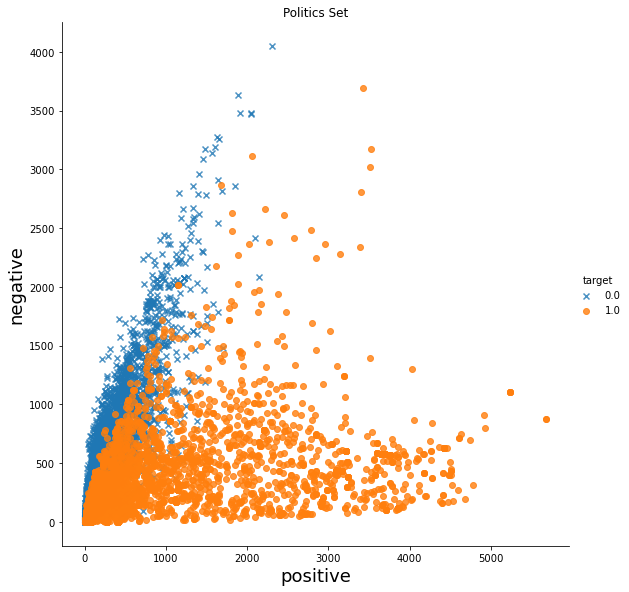

In [27]:
plt.figure(figsize=(10,10))
#plt.scatter(x='positive', y='negative', data=vis_data, c=vis_data.target, alpha=0.8, cmap='viridis', s=15)
sns.lmplot(x='positive', y='negative', data=vis_data, hue='target', fit_reg=False, height=8, markers=['x','o'])
plt.title('Politics Set')
plt.xlabel('positive', fontsize=18)
plt.ylabel('negative', fontsize=18) 
plt.show() 

# Classifier  1 : Logistic Regression 

* The sigmoid function is defined as: 

$$ h(z) = \frac{1}{1+\exp^{-z}} $$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 


# 1.1 Apply Logistic Regression and Cross - Validation 

* As a reminder, We have a balanced dataset. 

In [28]:
cross_val_score(LogisticRegression(), X, y.ravel())

array([0.823125, 0.816875, 0.82625 , 0.81625 , 0.840625])

- We have very satisfying results. Let's do some hyper-parameter tuning.

# 1.2 Grid Search on Logistic Regression

In [29]:
%%time
gs_model = LogisticRegression(solver='liblinear') 
space = {
    'C': [1e-10,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}

search = GridSearchCV(gs_model, space, scoring='accuracy', cv = 5) 
search.fit(X, y.ravel())  

CPU times: total: 969 ms
Wall time: 411 ms


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100]},
             scoring='accuracy')

In [30]:
print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)

Best Score: 0.8247500000000001
Best Hyperparameters: {'C': 0.1}


In [31]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007788,0.002984,0.000789,0.000395,0.0,{'C': 1e-10},0.748750,0.748750,0.745625,0.746875,0.766875,0.751375,0.007840,9
1,0.008392,0.001630,0.000798,0.000746,0.00001,{'C': 1e-05},0.823125,0.811250,0.825625,0.808750,0.830625,0.819875,0.008454,7
2,0.008770,0.002123,0.000798,0.000399,0.0001,{'C': 0.0001},0.823125,0.810000,0.825625,0.809375,0.829375,0.819500,0.008258,8
3,0.008178,0.002555,0.000399,0.000489,0.001,{'C': 0.001},0.826250,0.813750,0.830000,0.808125,0.833750,0.822375,0.009798,6
4,0.006984,0.000902,0.001196,0.000403,0.01,{'C': 0.01},0.821875,0.816250,0.825000,0.816875,0.840625,0.824125,0.008862,5
5,0.006586,0.000494,0.000601,0.000491,0.1,{'C': 0.1},0.823125,0.816875,0.826875,0.816250,0.840625,0.824750,0.008871,1
6,0.006925,0.000728,0.000588,0.000481,1,{'C': 1},0.823125,0.816875,0.826250,0.816250,0.840625,0.824625,0.008844,2
7,0.007181,0.000768,0.000799,0.000400,10,{'C': 10},0.823125,0.816875,0.826250,0.816250,0.840625,0.824625,0.008844,2
8,0.007361,0.001031,0.000597,0.000488,100,{'C': 100},0.823125,0.816875,0.826250,0.816250,0.840625,0.824625,0.008844,2


In [32]:
search.best_score_

0.8247500000000001

In [102]:
search.best_estimator_

LogisticRegression(C=0.1, solver='liblinear')

# Test Logistic Regression Model

In [33]:
test_x_arr = generate_tweets_list(test_x)

In [34]:
X_test = np.zeros((len(test_x_arr), 3))
for i in range(len(test_x_arr)):
    X_test[i, :]= extract_features(test_x_arr[i], freqs) 
    
X_test[:5]

array([[1.000e+00, 5.150e+02, 5.520e+02],
       [1.000e+00, 2.174e+03, 4.300e+02],
       [1.000e+00, 3.240e+02, 4.230e+02],
       [1.000e+00, 2.240e+02, 2.330e+02],
       [1.000e+00, 4.850e+02, 1.890e+02]])

In [35]:
search.best_estimator_.score(X_test, test_y.ravel())

0.7105105105105105

In [36]:
y_hat = search.best_estimator_.predict(X_test)
print("F1-Score is", f1_score(test_y.ravel(), y_hat))

F1-Score is 0.7587587587587589


In [37]:
y_hat = search.best_estimator_.predict(X_test)
print("Precision is", precision_score(test_y.ravel(), y_hat))

Precision is 0.7359223300970874


In [38]:
y_hat = search.best_estimator_.predict(X_test)
print("Recall is", recall_score(test_y.ravel(), y_hat))

Recall is 0.7830578512396694


# Classifier 2 : SVM 

In [39]:
clf_svm = SVC(kernel='linear') 
clf_svm.fit(X, y.ravel())

SVC(kernel='linear')

In [40]:
clf_svm.score(X_test, test_y.ravel())

0.6912912912912913

In [41]:
clf_svm.score(X, y.ravel())

0.806875

In [42]:
clf_svm.coef0

0.0

In [43]:
clf_svm.coef_

array([[ 2.82170731e-10,  6.24213563e-03, -6.52182399e-03]])

# 2.1 Cross-Validation on Simple SVM Model 

In [44]:
cross_val_score(SVC(kernel='linear'), X, y.ravel(), cv=5)

array([0.80125 , 0.8     , 0.81    , 0.794375, 0.82875 ])

# 2.2 SVM Grid Search on Linear Kernel 

In [45]:
param_grid = {
    'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0], 
    'kernel' : ['linear']
}

grid_svm_linear = GridSearchCV(SVC(), param_grid, refit=3, verbose=3, cv=5)
grid_svm_linear.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ............C=1e-05, kernel=linear;, score=0.801 total time=   1.3s
[CV 2/5] END ............C=1e-05, kernel=linear;, score=0.799 total time=   1.2s
[CV 3/5] END ............C=1e-05, kernel=linear;, score=0.807 total time=   1.5s
[CV 4/5] END ............C=1e-05, kernel=linear;, score=0.797 total time=   1.1s
[CV 5/5] END ............C=1e-05, kernel=linear;, score=0.827 total time=   1.3s
[CV 1/5] END ...........C=0.0001, kernel=linear;, score=0.799 total time=   2.0s
[CV 2/5] END ...........C=0.0001, kernel=linear;, score=0.799 total time=   2.0s
[CV 3/5] END ...........C=0.0001, kernel=linear;, score=0.810 total time=   2.0s
[CV 4/5] END ...........C=0.0001, kernel=linear;, score=0.796 total time=   2.0s
[CV 5/5] END ...........C=0.0001, kernel=linear;, score=0.826 total time=   2.1s
[CV 1/5] END ............C=0.001, kernel=linear;, score=0.799 total time=   5.3s
[CV 2/5] END ............C=0.001, kernel=linear;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0],
                         'kernel': ['linear']},
             refit=3, verbose=3)

In [46]:
grid_svm_linear.best_score_

0.806875

In [47]:
grid_svm_linear.best_estimator_

SVC(kernel='linear')

In [48]:
grid_svm_linear.best_estimator_.score(X_test, test_y.ravel())

0.6912912912912913

In [49]:
f1_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.7607076350093109

In [50]:
recall_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.6923728813559322

In [51]:
precision_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.84400826446281

In [96]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.7587587587587589 ,
        'precision':0.7359223300970874 , 
        'recall': 0.7830578512396694,
        'test accuracy' : 0.7105105105105105,
        'validation accuracy': 0.8247500000000001  
    },
    
    'Linear SVM': {
        'f1 score': 0.7607076350093109, 
        'precision':0.84400826446281, 
        'recall':0.6923728813559322 ,
        'test accuracy':  0.6912912912912913 ,
        'validation accuracy':  0.806875
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM
f1 score,0.758759,0.760708
precision,0.735922,0.844008
recall,0.783058,0.692373
test accuracy,0.710511,0.691291
validation accuracy,0.824750,0.806875


# 2.3 Grid Search on SVM RBF Kernel 

In [53]:
%%time
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid_svm_rbf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
grid_svm_rbf.fit(X, y.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.554 total time=   5.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.567 total time=   5.6s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.556 total time=   5.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.559 total time=   5.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.569 total time=   5.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.574 total time=   5.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.586 total time=   5.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.574 total time=   5.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.579 total time=   5.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.588 total time=   5.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.629 total time=   4.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.674 total time=   4.3s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.670 total time=   4.3s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.666 total time=   4.4s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.681 total time=   4.3s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.674 total time=   6.5s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.692 total time=   5.2s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.682 total time=   5.2s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.673 total time=   5.2s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.696 total time=   5.7s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.693 total time=  13.1s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.696 total time=  12.9s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.712 total time=  15.4s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [54]:
grid_svm_rbf.best_score_

0.8286250000000001

In [55]:
grid_svm_rbf.best_estimator_.score(X_test, test_y.ravel())

0.7009009009009008

In [56]:
f1_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.7417012448132779

In [57]:
precision_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.7386363636363636

In [58]:
recall_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.7447916666666666

In [98]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.7587587587587589 ,
        'precision':0.7359223300970874 , 
        'recall': 0.7830578512396694,
        'test accuracy' : 0.7105105105105105,
        'validation accuracy': 0.8247500000000001  
    },
    
    'Linear SVM': {
        'f1 score': 0.7607076350093109, 
        'precision':0.84400826446281, 
        'recall':0.6923728813559322 ,
        'test accuracy':  0.6912912912912913 ,
        'validation accuracy':  0.806875
    },
    
    'RBF SVM' : {
        'f1 score': 0.7417012448132779, 
        'precision':0.7386363636363636,
        'recall': 0.7447916666666666,
        'test accuracy': 0.7009009009009008,
        'validation accuracy': 0.8286250000000001
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM,RBF SVM
f1 score,0.758759,0.760708,0.741701
precision,0.735922,0.844008,0.738636
recall,0.783058,0.692373,0.744792
test accuracy,0.710511,0.691291,0.700901
validation accuracy,0.824750,0.806875,0.828625


# 3. Naive Bayes Classifier 

In [60]:
def count_tweets(tweets, ys):
    '''
    Input:
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''
    result = dict() 
    
    for y, tweet in zip(ys, tweets):
        for word in tweet:
          
            pair = (word,y)
            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1
            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1
   
    return result

In [61]:
freqs = count_tweets(train_x_arr, train_y.squeeze())

In [62]:
freqs

{('know', 1.0): 184,
 ('effect', 1.0): 36,
 ('exercis', 1.0): 73,
 ('leg', 1.0): 55,
 ('tricki', 1.0): 1,
 ('design', 1.0): 8,
 ('quick', 1.0): 19,
 ('15', 1.0): 14,
 ('min', 1.0): 1,
 ('workout', 1.0): 254,
 ('knock', 1.0): 2,
 ('park', 1.0): 10,
 ('next', 1.0): 62,
 ('day', 1.0): 154,
 ('one', 1.0): 162,
 ('els', 1.0): 6,
 ('back', 1.0): 96,
 ('shoulder', 1.0): 11,
 ('like', 1.0): 106,
 ('us', 1.0): 377,
 ('💯', 1.0): 2,
 ('stress', 1.0): 34,
 ('😩', 1.0): 3,
 ('tire', 1.0): 5,
 ('😴', 1.0): 3,
 ('worn', 1.0): 2,
 ('😰', 1.0): 3,
 ('common', 1.0): 20,
 ("they'r", 1.0): 22,
 ('perfect', 1.0): 56,
 ('reason', 1.0): 38,
 ('come', 1.0): 45,
 ('gym', 1.0): 362,
 ('work', 1.0): 96,
 ('promis', 1.0): 13,
 ('leav', 1.0): 15,
 ('feel', 1.0): 77,
 ('littl', 1.0): 32,
 ('relax', 1.0): 3,
 ('energ', 1.0): 5,
 ('readi', 1.0): 27,
 ('tackl', 1.0): 4,
 ("what'", 1.0): 21,
 ('ahead', 1.0): 20,
 ("that'", 1.0): 27,
 ('realaf', 1.0): 7,
 ('time', 1.0): 159,
 ('get', 1.0): 279,
 ('rockin', 1.0): 1,
 ('foam

In [63]:
def lookup(freqs, word, label):
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [64]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [65]:
logprior, loglikelihood = train_naive_bayes(freqs=freqs, train_x=train_x_arr, train_y=train_y.squeeze())

In [66]:
logprior

0.0

In [67]:
loglikelihood

{'athlet': 0.9867509089482912,
 'carrol': -0.8377983831027547,
 '🗓': -0.4323332749945904,
 'vladimirputon': -0.8377983831027547,
 'three-tim': -0.8377983831027547,
 'purest': -0.4323332749945904,
 'extrem': -0.5501163106509739,
 'precor': 1.6471082666852455,
 '33rd': -0.4323332749945904,
 'puerto': -0.4323332749945904,
 'caught': -0.2500117182006357,
 'wildflow': -0.4323332749945904,
 'notifi': -0.8377983831027547,
 'cryptic': -1.3486240068687454,
 'moor': 1.3594261942334647,
 'chrome': -0.4323332749945904,
 "yesterday'": -0.4323332749945904,
 '7.9': -0.4323332749945904,
 'partak': 0.9539610861253003,
 'reno': 0.9539610861253003,
 'closur': 1.17710463743951,
 'loan': -1.2432634912109193,
 'anyth': -0.8918656043730305,
 'univers': 0.39434529818987757,
 'appet': -0.14465120254280942,
 'longest-run': 0.9539610861253003,
 'daili': -0.9919490629300131,
 'rant': -0.8377983831027547,
 'children': -1.9904778930411402,
 'book': 0.1655037257610302,
 'lemongrass': -0.4323332749945904,
 '5-5': -0.

## p = logprior + sum_i(loglikelihood_i)

In [68]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a processed tweet
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    p = 0
    # add the logprior
    p += logprior

    for word in tweet:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p

In [69]:
tweet = train_x_arr[0]
p = naive_bayes_predict(tweet, logprior, loglikelihood) 
p

27.766763210930755

In [70]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        y_hats.append(y_hat_i)

    error = np.mean(np.absolute(y_hats-test_y))
    accuracy = 1-error
    
    return accuracy

In [71]:
test_naive_bayes(test_x_arr, test_y.squeeze(), logprior, loglikelihood) 

0.7543543543543544

In [72]:
test_naive_bayes(train_x_arr, np.squeeze(train_y), logprior, loglikelihood)

0.9295

In [73]:
y_hats =[naive_bayes_predict(item, logprior, loglikelihood) > 0 if 1 else 0 for item in test_x_arr]

In [74]:
f1_score(np.squeeze(test_y), y_hats)

0.7695774647887325

In [75]:
precision_score(np.squeeze(test_y), y_hats)

0.8463444857496902

In [76]:
recall_score(np.squeeze(test_y), y_hats)

0.7055785123966942

In [99]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.7587587587587589 ,
        'precision':0.7359223300970874 , 
        'recall': 0.7830578512396694,
        'test accuracy' : 0.7105105105105105,
        'validation accuracy': 0.8247500000000001  
    },
    
    'Linear SVM': {
        'f1 score': 0.7607076350093109, 
        'precision':0.84400826446281, 
        'recall':0.6923728813559322 ,
        'test accuracy':  0.6912912912912913 ,
        'validation accuracy':  0.806875
    },
    
    'RBF SVM' : {
        'f1 score': 0.7417012448132779, 
        'precision':0.7386363636363636,
        'recall': 0.7447916666666666,
        'test accuracy': 0.7009009009009008,
        'validation accuracy': 0.8286250000000001
    },
    
    'Naive Bayes' : {
        'f1 score': 0.7695774647887325, 
        'precision':0.8463444857496902, 
        'recall': 0.7055785123966942,
        'test accuracy': 0.7543543543543544,
        'validation accuracy': 0.9295
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM,RBF SVM,Naive Bayes
f1 score,0.758759,0.760708,0.741701,0.769577
precision,0.735922,0.844008,0.738636,0.846344
recall,0.783058,0.692373,0.744792,0.705579
test accuracy,0.710511,0.691291,0.700901,0.754354
validation accuracy,0.824750,0.806875,0.828625,0.929500


# Implemenet Naive Bayes With Sklearn 

In [78]:
from sklearn.naive_bayes import MultinomialNB

In [79]:
train_x_non_array = [' '.join(item) for item in train_x_arr] 
train_x_non_array[:5] 

['know effect exercis leg tricki design quick effect 15 min workout knock park next leg day one els back shoulder leg like us 💯',
 "stress 😩 tire 😴 worn 😰 common they'r perfect reason come gym work us promis leav feel littl relax energ readi tackl what' ahead that' realaf",
 'time get rockin foam rollin last time show way use foam roller massag sore muscl use versatil tool stretch far beyond whether pre post-workout stretch time feel differ foam make',
 'hi zach pleas dm us thank',
 'hi thank reach account manag gym usa canada intern gym independ own oper manag master franchise recommend contact via email complaince@anytimefitness.in thank']

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

In [81]:
vectorizer = CountVectorizer() 

In [82]:
vectorizer.fit(train_x_non_array)

CountVectorizer()

In [83]:
train_x_for_naivebayes = vectorizer.transform(train_x_non_array)

In [84]:
len(train_x_arr)

8000

In [85]:
len(vectorizer.vocabulary_)

9585

In [86]:
classifier_nb = MultinomialNB()

In [87]:
classifier_nb.fit(train_x_for_naivebayes.toarray(), np.squeeze(train_y))

MultinomialNB()

In [88]:
classifier_nb.score(train_x_for_naivebayes.toarray(), np.squeeze(train_y))

0.922625

In [89]:
test_x_non_array = [' '.join(item) for item in test_x_arr] 
test_x_non_array[:5]

['openfit chief digit offic selina tobaccowala founder evit former presid survey monkey offer club …',
 'openfit chief digit offic selina tobaccowala founder evit former presid survey monkey offer club industri execut summit keynot fit access health well fit gym studio',
 'egym get million invest u product expans',
 'peloton look hospit market expans',
 "check 4 short video present sale market practic today' consum workshop execut summit nov 8-10 tip sale market practic"]

In [90]:
text_x_vectorized = vectorizer.transform(test_x_non_array)

In [91]:
classifier_nb.score(text_x_vectorized, np.squeeze(test_y))

0.7543543543543544

In [92]:
model_nb = (logprior, loglikelihood)

In [95]:
logprior

0.0

In [94]:
loglikelihood

{'athlet': 0.9867509089482912,
 'carrol': -0.8377983831027547,
 '🗓': -0.4323332749945904,
 'vladimirputon': -0.8377983831027547,
 'three-tim': -0.8377983831027547,
 'purest': -0.4323332749945904,
 'extrem': -0.5501163106509739,
 'precor': 1.6471082666852455,
 '33rd': -0.4323332749945904,
 'puerto': -0.4323332749945904,
 'caught': -0.2500117182006357,
 'wildflow': -0.4323332749945904,
 'notifi': -0.8377983831027547,
 'cryptic': -1.3486240068687454,
 'moor': 1.3594261942334647,
 'chrome': -0.4323332749945904,
 "yesterday'": -0.4323332749945904,
 '7.9': -0.4323332749945904,
 'partak': 0.9539610861253003,
 'reno': 0.9539610861253003,
 'closur': 1.17710463743951,
 'loan': -1.2432634912109193,
 'anyth': -0.8918656043730305,
 'univers': 0.39434529818987757,
 'appet': -0.14465120254280942,
 'longest-run': 0.9539610861253003,
 'daili': -0.9919490629300131,
 'rant': -0.8377983831027547,
 'children': -1.9904778930411402,
 'book': 0.1655037257610302,
 'lemongrass': -0.4323332749945904,
 '5-5': -0.

# Save The Best Model 

## Pickle 

It allows you to serialize your python object into a file.

In [103]:
with open('fitness_logisticreg.', 'wb') as f: 
    pickle.dump(search.best_estimator_, f)

In [104]:
with open('fitness_logisticreg.', 'rb') as f: 
    model_pickle = pickle.load(f)

In [105]:
type(model_pickle)

sklearn.linear_model._logistic.LogisticRegression

In [106]:
model_pickle.predict(X_test)

array([1., 1., 0., ..., 0., 0., 1.])